## TP 4 : Méthode des éléments finis

In [1]:
import numpy as np
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import matplotlib.pyplot as plt

## Partie 1. (Elements finis P1)

### 1 2

In [2]:
class mesh:
    def __init__(self, Nel, xmin=0.0, xmax=1.0):
        self.Nel = Nel
        self.Ndof = Nel + 1
        self.xmin = 0.0
        self.xmax = 1.0
        self.nodes = np.empty(Nel + 1)
        self.h = np.empty(Nel)

    def init_uniform(self):
        self.nodes = np.linspace(self.xmin, self.xmax, self.Ndof)
        self.h = np.diff(self.nodes)

    def init_random(self):
        self.nodes = self.xmin + (self.xmax - self.xmin) * np.random.rand(self.Ndof)
        self.nodes[0] = self.xmin
        self.nodes[1] = self.xmax
        self.nodes.sort()
        self.h = np.diff(self.nodes)

    def test(self):
        self.init_uniform()
        print("Nodes:", self.nodes)
        print("Element sizes:", self.h)
        self.init_random()
        print("Nodes:", self.nodes)
        print("Element sizes:", self.h)

mh = mesh(4, 0, 1)
mh.test()

Nodes: [0.   0.25 0.5  0.75 1.  ]
Element sizes: [0.25 0.25 0.25 0.25]
Nodes: [0.         0.03130856 0.63770074 0.66811103 1.        ]
Element sizes: [0.03130856 0.60639218 0.03041029 0.33188897]


### 3 4 5 7

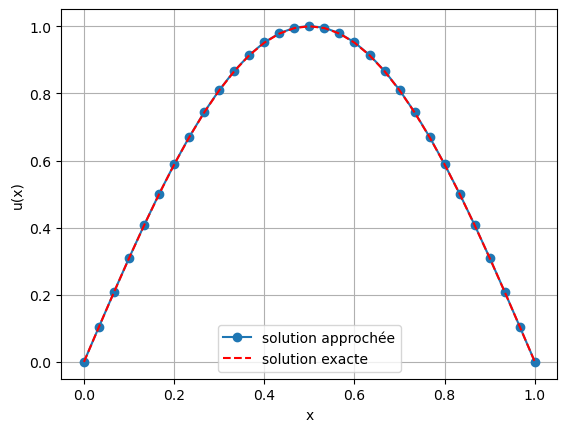

In [3]:
class fem:
    def __init__(self, mesh):
        self.mesh = mesh

    def matrixA_P1(self):
        h = self.mesh.h

        diagK = (1/h[:-1] + 1/h[1:])
        offdiagK = -1/h[1:-1]

        diagM = (h[:-1] + h[1:]) / 3.0
        offdiagM = h[1:-1] / 6.0

        diagA = diagK + diagM
        offdiagA = offdiagK + offdiagM

        A = spsp.diags([offdiagA, diagA, offdiagA], offsets=[-1,0,1], format='csr')

        return A

    def rhs_P1(self,f):
        nodes = self.mesh.nodes
        h = self.mesh.h
        Ndof = self.mesh.Ndof
        b = np.zeros(Ndof)

        for i in range(self.mesh.Nel):
            x_left = nodes[i]
            x_right = nodes[i+1]

            b[i] += h[i] * f(x_left) / 2.0
            b[i+1] += h[i] * f(x_right) / 2.0

        return b[1:-1]
    
    def solve(self, f, plot=True):
        A = self.matrixA_P1()
        b = self.rhs_P1(f)

        uu = spsplin.spsolve(A, b)

        Ndof = self.mesh.Ndof
        u = np.zeros(Ndof)
        u[1:-1] = uu

        if plot:
            x = self.mesh.nodes

            test_val = f(0.5)
            u_exact = np.sin(np.pi*x)

            plt.figure()
            plt.plot(x, u, 'o-', label='solution approchée')
            plt.plot(x, u_exact, 'r--', label='solution exacte')
            plt.xlabel('x')
            plt.ylabel('u(x)')
            plt.legend()
            plt.grid(True)
            plt.show()

        return u

mh = mesh(30, 0, 1)
mh.init_uniform()
fe = fem(mh)

A = fe.matrixA_P1()

# print(A.toarray())

def f_test(x):
    return (np.pi**2+1)*np.sin(np.pi*x)

u_approx = fe.solve(f_test, plot=True)

### 6

Let $u(x) = \sin(\pi x)$ in $-u''(x) + u(x) = f(x)$：

$u(x) = \sin(\pi x) \quad \Rightarrow \quad u'(x) = \pi \cos(\pi x) \quad \Rightarrow \quad u''(x) = -\pi^2 \sin(\pi x)$

$-(-\pi^2 \sin(\pi x)) + \sin(\pi x) = f(x)$

$f(x) = (\pi^2 + 1) \sin(\pi x)$

## Partie 2. (Etude)

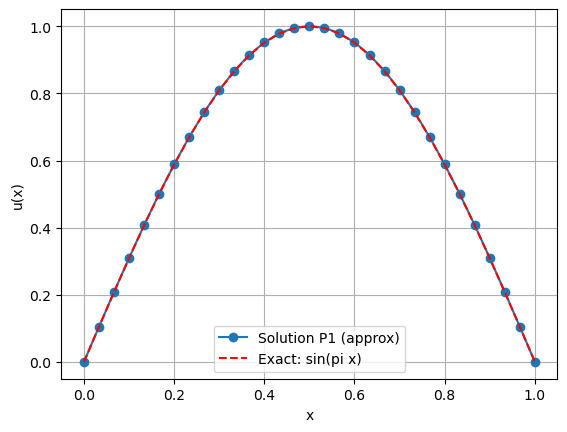

L2 error with Nel=30: 0.0004987767025623769


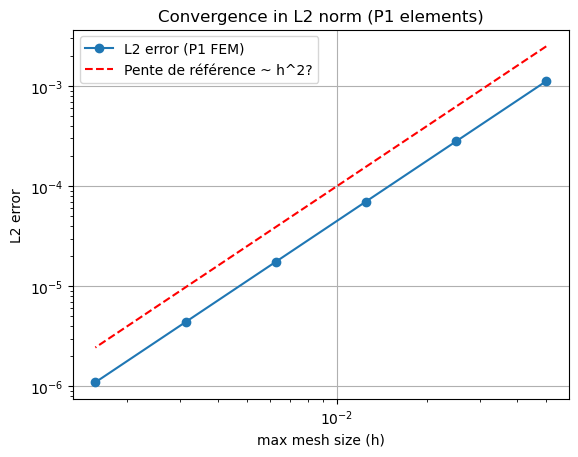

Nel=20 -> Nel=40:  ordre d'erreur = 2.00
Nel=40 -> Nel=80:  ordre d'erreur = 2.00
Nel=80 -> Nel=160:  ordre d'erreur = 2.00
Nel=160 -> Nel=320:  ordre d'erreur = 2.00
Nel=320 -> Nel=640:  ordre d'erreur = 2.00
===== cond(A) test =====
Nel = 20:
  - uniform cond(A)  = 1.47e+02
  - random cond(A)  = 1.48e+03
Nel = 40:
  - uniform cond(A)  = 5.88e+02
  - random cond(A)  = 8.78e+03
Nel = 80:
  - uniform cond(A)  = 2.35e+03
  - random cond(A)  = 4.64e+04
Nel = 160:
  - uniform cond(A)  = 9.42e+03
  - random cond(A)  = 1.00e+06


In [4]:
class mesh:
    def __init__(self, Nel, xmin=0.0, xmax=1.0):
        self.Nel = Nel
        self.Ndof = Nel + 1
        self.xmin = xmin
        self.xmax = xmax
        self.nodes = np.empty(self.Ndof)
        self.h = np.empty(self.Nel)

    def init_uniform(self):
        self.nodes = np.linspace(self.xmin, self.xmax, self.Ndof)
        self.h = np.diff(self.nodes)

    def init_random(self):
        self.nodes = self.xmin + (self.xmax - self.xmin) * np.random.rand(self.Ndof)
        self.nodes[0] = self.xmin
        self.nodes[-1] = self.xmax
        self.nodes.sort()
        self.h = np.diff(self.nodes)

    def norm_P1(self, u):
        L2_sq = 0.0
        H1_semi_sq = 0.0
        for i in range(self.Nel):
            hi = self.h[i]
            ui = u[i]
            ui1 = u[i+1]

            L2_sq += (hi / 6.0) * (ui**2 + ui1**2 + ui*ui1)

            H1_semi_sq += (ui1 - ui)**2 / hi

        L2_norm = np.sqrt(L2_sq)
        H1_seminorm = np.sqrt(H1_semi_sq)
        return (L2_norm, H1_seminorm)

class fem:
    def __init__(self, mesh):
        self.mesh = mesh

    def matrixA_P1(self):
        h = self.mesh.h
        Nel = self.mesh.Nel
        Ndof = self.mesh.Ndof

        diagK = np.zeros(Ndof-2)
        for i in range(1, Ndof-1):
            diagK[i-1] = 1.0/h[i-1] + 1.0/h[i]

        offK = np.zeros(Ndof-3)
        for i in range(1, Ndof-2):
            offK[i-1] = -1.0/h[i]

        diagM = np.zeros(Ndof-2)
        for i in range(1, Ndof-1):
            diagM[i-1] = (h[i-1] + h[i]) / 3.0

        offM = np.zeros(Ndof-3)
        for i in range(1, Ndof-2):
            offM[i-1] = h[i] / 6.0

        diagA = diagK + diagM
        offA = offK + offM

        A = spsp.diags([offA, diagA, offA], offsets=[-1,0,1], format='csr')
        return A

    def rhs_P1(self, f):
        nodes = self.mesh.nodes
        h = self.mesh.h
        Ndof = self.mesh.Ndof

        b_full = np.zeros(Ndof)
        for i in range(self.mesh.Nel):
            x_left = nodes[i]
            x_right = nodes[i+1]
            b_full[i]   += 0.5 * h[i] * f(x_left)
            b_full[i+1] += 0.5 * h[i] * f(x_right)

        return b_full[1:-1]

    def solve(self, f, plot=True, return_error=True):
        A = self.matrixA_P1()
        b = self.rhs_P1(f)
        
        u_inner = spsplin.spsolve(A, b)
        Ndof = self.mesh.Ndof
        u = np.zeros(Ndof)
        u[1:-1] = u_inner

        x = self.mesh.nodes
        u_exact = np.sin(np.pi*x)

        if plot:
            plt.figure()
            plt.plot(x, u, 'o-', label='Solution P1 (approx)')
            plt.plot(x, u_exact, 'r--', label='Exact: sin(pi x)')
            plt.xlabel('x')
            plt.ylabel('u(x)')
            plt.legend()
            plt.grid(True)
            plt.show()

        ##########################################
        if return_error:
            e = u - u_exact
            L2_e, _ = self.mesh.norm_P1(e)
            return u, L2_e
        else:
            return u


# Test

def f_test(x):
    return (np.pi**2 + 1)*np.sin(np.pi*x)

def test_convergence():
    Nel_list = [20, 40, 80, 160, 320, 640]
    h_list = []
    err_list = []

    for Nel in Nel_list:
        mh = mesh(Nel, 0, 1)
        mh.init_uniform()
        h_list.append(np.max(mh.h))

        fe = fem(mh)
        _, L2_error = fe.solve(f_test, plot=False, return_error=True)
        err_list.append(L2_error)
    
    plt.figure()
    plt.loglog(h_list, err_list, 'o-', label='L2 error (P1 FEM)')
    plt.loglog(h_list, [h**2 for h in h_list], 'r--', label='Pente de référence ~ h^2?')  
    plt.xlabel('max mesh size (h)')
    plt.ylabel('L2 error')
    plt.title('Convergence in L2 norm (P1 elements)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # slope = log(err[i]/err[i+1]) / log(h[i]/h[i+1])
    for i in range(len(Nel_list)-1):
        order = np.log(err_list[i]/err_list[i+1]) / np.log(h_list[i]/h_list[i+1])
        print(f"Nel={Nel_list[i]} -> Nel={Nel_list[i+1]}:  ordre d'erreur = {order:.2f}")


def test_condition_number():
    Nel_list = [20, 40, 80, 160]

    print("===== cond(A) test =====")
    for Nel in Nel_list:
        mh_uni = mesh(Nel, 0, 1)
        mh_uni.init_uniform()
        fe_uni = fem(mh_uni)
        A_uni = fe_uni.matrixA_P1().toarray()
        cond_uni = np.linalg.cond(A_uni)

        mh_rand = mesh(Nel, 0, 1)
        mh_rand.init_random()
        fe_rand = fem(mh_rand)
        A_rand = fe_rand.matrixA_P1().toarray()
        cond_rand = np.linalg.cond(A_rand)

        print(f"Nel = {Nel}:")
        print(f"  - uniform cond(A)  = {cond_uni:.2e}")
        print(f"  - random cond(A)  = {cond_rand:.2e}")

if __name__ == "__main__":
    mh = mesh(30, 0, 1)
    mh.init_uniform()
    fe = fem(mh)

    u_approx, L2_err = fe.solve(f_test, plot=True, return_error=True)
    print("L2 error with Nel=30:", L2_err)

    test_convergence()

    test_condition_number()


Théoriquement, pour les éléments finis linéaires (P1), on observe souvent une convergence de l'ordre de ~$ h^1$ dans l'espace $H^1$, et jusqu'à ~$h^2$ dans l'espace $L^2$.

## Partie 3 (Eléments finis P_2).

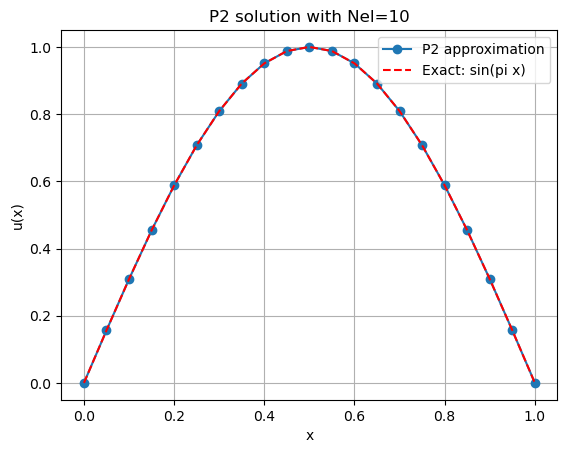

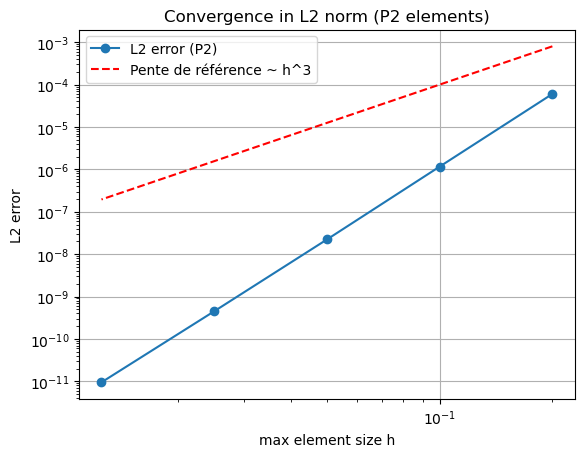

Nel=5 -> 10,  ordre d'erreur ~ 5.69
Nel=10 -> 20,  ordre d'erreur ~ 5.71
Nel=20 -> 40,  ordre d'erreur ~ 5.63
Nel=40 -> 80,  ordre d'erreur ~ 5.57


In [5]:
class mesh:
    def __init__(self, Nel, xmin=0.0, xmax=1.0, deg=2):
        self.Nel = Nel
        self.xmin = xmin
        self.xmax = xmax
        self.deg = deg  # 2

        self.Ndof = self.deg * self.Nel + 1

        self.nodes_base = np.empty(self.Nel+1)
        self.h = np.empty(self.Nel)

        self.dof = np.empty(self.Ndof)

    def init_uniform(self):
        self.nodes_base = np.linspace(self.xmin, self.xmax, self.Nel+1)
        self.h = np.diff(self.nodes_base)

        idx_global = 0
        for el in range(self.Nel):
            xL = self.nodes_base[el]
            xR = self.nodes_base[el+1]
            h_el = xR - xL

            for k in range(self.deg+1):
                self.dof[idx_global] = xL + (k/self.deg)*h_el
                idx_global += 1

            if el < self.Nel-1:
                idx_global -= 1

    def init_random(self):
        random_pts = np.random.rand(self.Nel-1)
        random_pts.sort()
        self.nodes_base[0] = self.xmin
        self.nodes_base[-1] = self.xmax
        for i in range(1, self.Nel):
            self.nodes_base[i] = self.xmin + (self.xmax - self.xmin)*random_pts[i-1]

        self.nodes_base.sort()
        self.h = np.diff(self.nodes_base)

        idx_global = 0
        for el in range(self.Nel):
            xL = self.nodes_base[el]
            xR = self.nodes_base[el+1]
            h_el = xR - xL
            for k in range(self.deg+1):
                self.dof[idx_global] = xL + (k/self.deg)*h_el
                idx_global += 1
            if el < self.Nel-1:
                idx_global -= 1

    def connect(self, el, k):
        return el*self.deg + k

class femP2:
    def __init__(self, mesh):
        self.mesh = mesh
        self.M_ref = np.array([[ 2.0,  1.0, -0.5],
                               [ 1.0,  8.0,  1.0],
                               [-0.5, 1.0,  2.0]]) / 15.0

        self.K_ref = np.array([[ 7.0, -8.0,  1.0],
                               [-8.0,16.0, -8.0],
                               [ 1.0, -8.0,  7.0]]) / 3.0

    def matrixA(self):
        Nel = self.mesh.Nel
        Ndof = self.mesh.Ndof
        dof = self.mesh.dof
        h_all = self.mesh.h

        A_dok = spsp.dok_matrix((Ndof, Ndof), dtype=float)

        for el in range(Nel):
            h_el = h_all[el]
            inv_h = 1.0 / h_el

            for ni in range(self.mesh.deg+1):
                i = self.mesh.connect(el, ni)
                for nj in range(self.mesh.deg+1):
                    j = self.mesh.connect(el, nj)
                    valK = inv_h * self.K_ref[ni, nj]
                    valM = h_el * self.M_ref[ni, nj]
                    A_dok[i, j] += (valK + valM)

        A = A_dok.tocsr()
        return A

    def rhs(self, f):
        Nel = self.mesh.Nel
        Ndof = self.mesh.Ndof
        b = np.zeros(Ndof)
        dof = self.mesh.dof

        w_simp = np.array([1.0/6.0, 4.0/6.0, 1.0/6.0])
        y_simp = np.array([0.0, 0.5, 1.0])

        def phi_bar0(y):
            return (2.0*y - 1.0)*(y - 1.0)
        def phi_bar1(y):
            return 4.0*y*(1.0 - y)
        def phi_bar2(y):
            return y*(2.0*y - 1.0)

        phi_vals = np.zeros((3, self.mesh.deg+1))
        for m in range(3):
            yy = y_simp[m]
            phi_vals[m,0] = phi_bar0(yy)
            phi_vals[m,1] = phi_bar1(yy)
            phi_vals[m,2] = phi_bar2(yy)

        for el in range(Nel):
            xL = self.mesh.nodes_base[el]
            xR = self.mesh.nodes_base[el+1]
            h_el = xR - xL

            for ni in range(self.mesh.deg+1):
                i = self.mesh.connect(el, ni)

                tmp_sum = 0.0
                for m in range(3):
                    x_m = xL + y_simp[m]*h_el
                    tmp_sum += w_simp[m] * f(x_m)* phi_vals[m, ni]

                b[i] += h_el * tmp_sum

        return b

    def norm(self, u):
        Nel = self.mesh.Nel
        Ndof = self.mesh.Ndof
        x_base = self.mesh.nodes_base
        h_all = self.mesh.h

        w_simp = np.array([1.0/6.0, 4.0/6.0, 1.0/6.0])
        y_simp = np.array([0.0, 0.5, 1.0])

        def phi_bar0(y):
            return (2.0*y - 1.0)*(y - 1.0)
        def phi_bar1(y):
            return 4.0*y*(1.0 - y)
        def phi_bar2(y):
            return y*(2.0*y - 1.0)

        phi_bar = [phi_bar0, phi_bar1, phi_bar2]

        L2_val = 0.0
        for el in range(Nel):
            xL = x_base[el]
            xR = x_base[el+1]
            h_el = xR - xL

            for m in range(3):
                y_m = y_simp[m]
                x_m = xL + y_m*h_el

                u_val = 0.0
                for k in range(self.mesh.deg+1):
                    idx_g = self.mesh.connect(el, k)
                    u_val += u[idx_g] * phi_bar[k](y_m)

                L2_val += w_simp[m] * (u_val**2)

            L2_val *= h_el

        L2_norm = np.sqrt(L2_val)
        return L2_norm

    def solve(self, f, plot=True):
        A = self.matrixA()
        b = self.rhs(f)
        Ndof = self.mesh.Ndof

        A = A.tolil()
        A[0,:] = 0.0
        A[0,0] = 1.0
        b[0]   = 0.0
        A[-1,:] = 0.0
        A[-1,-1] = 1.0
        b[-1]    = 0.0
        A = A.tocsc()

        u = spsplin.spsolve(A, b)

        if plot:
            x_dof = self.mesh.dof
            u_ex  = np.sin(np.pi * x_dof)

            plt.figure()
            plt.plot(x_dof, u, 'o-', label='P2 approximation')
            plt.plot(x_dof, u_ex, 'r--', label='Exact: sin(pi x)')
            plt.xlabel('x')
            plt.ylabel('u(x)')
            plt.legend()
            plt.grid(True)
            plt.title(f"P2 solution with Nel={self.mesh.Nel}")
            plt.show()

        return u


# Test

def f_test(x):
    return (np.pi**2 + 1.0)*np.sin(np.pi*x)

def test_convergence_p2():
    Nel_list = [5, 10, 20, 40, 80]
    h_list = []
    err_list = []

    for Nel in Nel_list:
        m = mesh(Nel=Nel, xmin=0.0, xmax=1.0, deg=2)
        m.init_uniform()
        
        fe = femP2(m)
        u_h = fe.solve(f_test, plot=False)

        x_dof = m.dof
        u_exact = np.sin(np.pi*x_dof)
        e = u_h - u_exact
        L2_e = fe.norm(e)

        h_list.append( np.max(m.h) )
        err_list.append(L2_e)

    # log-log
    plt.figure()
    plt.loglog(h_list, err_list, 'o-', label='L2 error (P2)')
    plt.loglog(h_list, [0.1*(h**3) for h in h_list], 'r--', label='Pente de référence ~ h^3')
    plt.xlabel('max element size h')
    plt.ylabel('L2 error')
    plt.title('Convergence in L2 norm (P2 elements)')
    plt.grid(True)
    plt.legend()
    plt.show()

    for i in range(len(Nel_list)-1):
        r = np.log(err_list[i]/err_list[i+1]) / np.log(h_list[i]/h_list[i+1])
        print(f"Nel={Nel_list[i]} -> {Nel_list[i+1]},  ordre d'erreur ~ {r:.2f}")

if __name__ == "__main__":
    m = mesh(Nel=10, xmin=0.0, xmax=1.0, deg=2)
    m.init_uniform()
    fe = femP2(m)

    u_sol = fe.solve(f_test, plot=True)

    test_convergence_p2()
